In [1]:
import pandas as pd
from pandas import option_context

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Tuple, Dict, Union, Optional
import random
import glob
random.seed(0)

import re

from generation_exp import get_best_checkpoint

pd.set_option('max_colwidth', 400) # avoid trimming cells
pd.set_option('display.max_columns', None) # avoid truncating columns
pd.set_option('display.max_rows', None) # avoid truncating rows

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
# seed_experiments = ['seed_193847', 'seed_23', 'seed_4', 'seed_42', 'seed_85', 'seed_9']
seed = 42

# exp_dir = Path(f'resources/models_v1/seed_{seed}')
exp_dir = Path(f'resources/models/seed_{seed}')

model_names = [p.name for p in Path(exp_dir / 'ft').iterdir()]
# large_model_names = ['bart_base', 'bert_base', 'roberta_base', 't5_small']
# large_model_names = [p.name for p in Path(exp_dir / 'ft').iterdir() if p.name in large_model_names]

models_path = exp_dir / 'ft'
results_path = exp_dir / 'results'
plot_path = results_path / 'plots'
plot_path.mkdir(parents=True, exist_ok=True)
print(model_names)
# print('Found mini models:\n\t', mini_model_names)
# print('Found large models:\n\t', large_model_names)

['roberta2roberta_small', 'bart_small-SI_bart', 'bart_small-MLM', 'bart_small-SI_PS', 'bart_small-MLM_DR', 'bart_base', 'bart_small-PS', 'bart_small-MLM_PS', 't5_small', 'roberta_small', 'bart_small-MLM_PS_DR', 'bart_small-SI_t5', 'bert_base', 'roberta_base', 'bart_small-SI_mass']


### Inspect generated outputs

In [6]:
def parse_generations_file_stem(stem: str) -> Tuple:
    parts = stem.split('_')
    if parts[-1] != 'tp=0.9':
        return (parts[-1], int(parts[2].split('=')[-1]))
    else:
        return ('default', int(parts[2].split('=')[-1]))
    
def quick_lc(file: Union[str, Path]) -> int:
    with open(file, 'rb') as f:
        return sum(1 for line in f)
    
def read_lines(file: Union[str, Path], line_indices: Optional[List[int]]=None) -> List[str]:
    lines = []
    with open(file, 'r', encoding='utf8') as f:
        for i, line in enumerate(f):
            if line_indices and i not in line_indices:
                pass
            else:
                lines.append(line.strip())
    return lines

def sample_line_indices(lc: int, n: int) -> List[int]:
    return random.sample(range(lc), n)
    
def get_outputs_dataframe(model_path: Path, sample_n: int = 10) -> pd.DataFrame:
    checkpoint_dir = get_best_checkpoint(model_path)
    file_list = list((model_path / f'{checkpoint_dir}/outputs').glob('generation*'))
    
    if sample_n > 0:
        expected_lc = quick_lc(file_list[0])
        sample_lines = sample_line_indices(expected_lc, sample_n)
        print(sample_lines)
    else:
        sample_lines = None
    
    d = {}
    for file in file_list:
        d[parse_generations_file_stem(file.stem)] = read_lines(file, sample_lines)
    # load dictionary into dataframe, splitting the key tuple into a multiIndex
    df = pd.DataFrame(d.values(), index=pd.MultiIndex.from_tuples(d.keys(), names=['gen_setting', 'seed']))
    
    df = df.sort_values(by=['gen_setting', 'seed'], ascending=True)
    return df

sampled_outputs = get_outputs_dataframe(models_path / 'roberta_small', sample_n=10)
# sampled_outputs = get_outputs_dataframe(models_path / 'bert_base', sample_n=10)
sampled_outputs

[3578, 8268, 2281, 4617, 2289, 1553, 4104, 8725, 2407, 5081]


0  \
gen_setting         seed                                                                        
ctxt=1-questions-10 0                                                     I do not know that.   
                    42                   I don't know that. Did you know that the first line?   
                    284                 I don't know that. Did you know that the yellow line?   
                    983             That is a great point. Did you know that the first first?   
                    8630                                                  I do not know that.   
ctxt=5-questions-10 0                    I don't know that. Did you know that the first line?   
                    42                                                    I do not know that.   
                    284                                                   I do not know that.   
                    983                                I think it is a lot of the first line.   
                    8630                                                 I did not know that.   
default             0                             Yeah, I think it's a lot of the first line.   
                    42              I don't know that. Did you know that the first line line?   
                    284             I don't know that. Did you know that the first line line?   
                    983                                                   I do not know that.   
                    8630                                          I think it is a good point.   
xatt=5-dialog       0           Yeah, it is a great game. I wonder if it was the yellow line.   
                    42                                   I don't know that. Do you know that?   
                    284                                                    I don't know that.   
                    983   I think it is a lot of the first line line line of the yellow line.   
                    8630                     I didn't know that. Did you know that the first?   
xatt=5-knowledge    0               I don't know that. Did you know that the first line line?   
                    42                  I don't know that. Did you know that the yellow line?   
                    284                  I'm not sure. Did you know that the first line line?   
                    983                                                   I do not know that.   
                    8630            I don't know that. Did you know that the first line line?   

                                                                                                        1  \
gen_setting         seed                                                                                    
ctxt=1-questions-10 0                                         I'm not sure. Did you know that the movies?   
                    42                                                   I'm not sure. I don't know that.   
                    284                           I don't know that. I wonder if it is a lot of the vote.   
                    983                          I think it is a lot of that. Did you know that the vote?   
                    8630                                       I'm not sure. Did you know that the voice?   
ctxt=5-questions-10 0                                                       I think it is a lot of funny.   
                    42                                                      I think it is a lot of money.   
                    284                        I think it is a lot of funny. Did you know that the voice?   
                    983                                    I don't know that. Did you know that the vote?   
                    8630                                                    I think it is a lot of money.   
default             0                         I think it is a lot of people. Did you know that the voice?   
                    42                                 

### Emprical analysis for question context controlled generation

In [7]:
INDEX_LEVELS = ['model', 'gen_setting', 'seed']

def parse_results_file_stem(file: Path) -> Tuple:
    """parses information from results file name, e.g. bart_small-SI_bart-qu_ctxt_aug5.csv """
    parts = file.stem.split('-')
    if len(parts) == 2:
        return parts[0], parts[1] # (model name, generation setting)
    else:
        model, pt_config, gen_setting = parts
        pt_config = pt_config.replace('_bart', '(BART)')
        pt_config = pt_config.replace('_t5', '(T5)')
        pt_config = pt_config.replace('_mass', '(MASS)')
        pt_config = pt_config.replace('_', '+')
        return pt_config, gen_setting
    
def flatten(l: List[List]) -> List:
    """flattens a list of lists"""
    return [item for sublist in l for item in sublist]

def load_results_dataframe(result_file_list: List, verbose: bool = False) -> pd.DataFrame:
    
    dfs = []
    for file in result_file_list:    
        if verbose:
            print(f'Loading data from {file} ...')
        df = pd.read_csv(file, sep=',', header=0, index_col=None)
        df['model'], df['gen_setting'] = parse_results_file_stem(file)
        df['file'] = file.stem
        dfs.append(df)

    df = pd.concat(dfs, axis=0).reset_index(drop=True)
    # standardise concatenated dataframe
    df['gen_setting'] = df['gen_setting'].apply(lambda x: 'default' if x == 'baseline' else x) # rename default generation setting
    df.set_index(INDEX_LEVELS, inplace=True)
    df = df.sort_values(by=INDEX_LEVELS, ascending=True)
    
    if verbose:
        print(f'\nResults table contains:')
        for col_name in df.columns.to_list():
              print(f'\t{col_name}')
        print(f'Dataframe index:')
        print(df.index)
        print(f'Dataframe has {len(df)} entries')
    return df

# result_file_list = flatten([list(results_path.glob(f'{model}*')) for model in mini_model_names])
# result_file_list = flatten([list(results_path.glob(f'{model}*')) for model in large_model_names])
result_file_list = list(results_path.glob(f'*.csv'))
print(len(result_file_list))
df = load_results_dataframe(result_file_list, verbose=True)
df

105
Loading data from resources/models/seed_42/results/roberta_small-xa_dialog+qu_ctxt_aug5.csv ...
Loading data from resources/models/seed_42/results/roberta_base-xa_dialog+qu_ctxt_aug5.csv ...
Loading data from resources/models/seed_42/results/roberta_small-qu_ctxt_aug1.csv ...
Loading data from resources/models/seed_42/results/bart_small-MLM_DR-xa_knowledge.csv ...
Loading data from resources/models/seed_42/results/bart_base-xa_dialog.csv ...
Loading data from resources/models/seed_42/results/bart_small-MLM_PS_DR-qu_ctxt_aug1.csv ...
Loading data from resources/models/seed_42/results/bart_small-MLM_DR-baseline.csv ...
Loading data from resources/models/seed_42/results/bart_small-SI_bart-xa_knowledge.csv ...
Loading data from resources/models/seed_42/results/t5_small-xa_knowledge+qu_ctxt_aug5.csv ...
Loading data from resources/models/seed_42/results/bert_base-baseline.csv ...
Loading data from resources/models/seed_42/results/roberta_small-xa_dialog.csv ...
Loading data from resourc

model_name_or_path  \
model                 gen_setting               seed                                                      
MLM                   default                   0            resources/models/seed_42/ft/bart_small-MLM   
                                                42           resources/models/seed_42/ft/bart_small-MLM   
                                                284          resources/models/seed_42/ft/bart_small-MLM   
                                                983          resources/models/seed_42/ft/bart_small-MLM   
                                                8630         resources/models/seed_42/ft/bart_small-MLM   
                      qu_ctxt_aug1              0            resources/models/seed_42/ft/bart_small-MLM   
                                                42           resources/models/seed_42/ft/bart_small-MLM   
                                                284          resources/models/seed_42/ft/bart_small-MLM   
                                                983          resources/models/seed_42/ft/bart_small-MLM   
                                                8630         resources/models/seed_42/ft/bart_small-MLM   
                      qu_ctxt_aug5              0            resources/models/seed_42/ft/bart_small-MLM   
                                                42           resources/models/seed_42/ft/bart_small-MLM   
                                                284          resources/models/seed_42/ft/bart_small-MLM   
                                                983          resources/models/seed_42/ft/bart_small-MLM   
                                                8630         resources/models/seed_42/ft/bart_small-MLM   
                      xa_dialog                 0            resources/models/seed_42/ft/bart_small-MLM   
                                                42           resources/models/seed_42/ft/bart_small-MLM   
                                                284          resources/models/seed_42/ft/bart_small-MLM   
                                                983          resources/models/seed_42/ft/bart_small-MLM   
                                                8630         resources/models/seed_42/ft/bart_small-MLM   
                      xa_dialog+qu_ctxt_aug5    0            resources/models/seed_42/ft/bart_small-MLM   
                                                42           resources/models/seed_42/ft/bart_small-MLM   
                                                284          resources/models/seed_42/ft/bart_small-MLM   
                                                983          resources/models/seed_42/ft/bart_small-MLM   
                                                8630         resources/models/seed_42/ft/bart_small-MLM   
                      xa_knowledge              0            resources/models/seed_42/ft/bart_small-MLM   
                                                42           resources/models/seed_42/ft/bart_small-MLM   
                                                284          resources/models/seed_42/ft/bart_small-MLM   
                                                983          resources/models/seed_42/ft/bart_small-MLM   
                                                8630         resources/models/seed_42/ft/bart_small-MLM   
                      xa_knowledge+qu_ctxt_aug5 0            resources/models/seed_42/ft/bart_small-MLM   
                                                42           resources/models/seed_42/ft/bart_small-MLM   
                                                284          resources/models/seed_42/ft/bart_small-MLM   
                                                983          resources/models/seed_42/ft/bart_small-MLM   
                                                8630         resources/models/seed_42/ft/bart_small-MLM   
MLM+DR                default                   0         resources/models/seed_42/ft/bart_small-MLM_DR   
                   

In [8]:
df.head()

model_name_or_path  \
model gen_setting seed                                               
MLM   default     0     resources/models/seed_42/ft/bart_small-MLM   
                  42    resources/models/seed_42/ft/bart_small-MLM   
                  284   resources/models/seed_42/ft/bart_small-MLM   
                  983   resources/models/seed_42/ft/bart_small-MLM   
                  8630  resources/models/seed_42/ft/bart_small-MLM   

                          checkpoint_dir  batch_size  \
model gen_setting seed                                 
MLM   default     0     checkpoint-72620       120.0   
                  42    checkpoint-72620       120.0   
                  284   checkpoint-72620       120.0   
                  983   checkpoint-72620       120.0   
                  8630  checkpoint-72620       120.0   

                                                             test_file  \
model gen_setting seed                                                   
MLM   default     0     resources/data/Topical-Chat/KGD/test_freq.json   
                  42    resources/data/Topical-Chat/KGD/test_freq.json   
                  284   resources/data/Topical-Chat/KGD/test_freq.json   
                  983   resources/data/Topical-Chat/KGD/test_freq.json   
                  8630  resources/data/Topical-Chat/KGD/test_freq.json   

                       text_column summary_column knowledge_column  \
model gen_setting seed                                               
MLM   default     0          turns         target        knowledge   
                  42         turns         target        knowledge   
                  284        turns         target        knowledge   
                  983        turns         target        knowledge   
                  8630       turns         target        knowledge   

                        max_length  do_sample  top_p  top_k  temperature  \
model gen_setting seed                                                     
MLM   default     0             40       True    0.9      0          0.7   
                  42            40       True    0.9      0          0.7   
                  284           40       True    0.9      0          0.7   
                  983           40       True    0.9      0          0.7   
                  8630          40       True    0.9      0          0.7   

                        beam_size  num_return_sequences write_to_file  \
model gen_setting seed                                                  
MLM   default     0             4                     1          auto   
                  42            4                     1          auto   
                  284           4                     1          auto   
                  983           4                     1          auto   
                  8630          4                     1          auto   

                        cross_attention_bias_value bias_profile  \
model gen_setting seed                                            
MLM   default     0                            NaN          NaN   
                  42                           NaN          NaN   
                  284                          NaN          NaN   
                  983                          NaN          NaN   
                  8630                         NaN          NaN   

                       context_augmentation_examples  \
model gen_setting seed                                 
MLM   default     0                              NaN   
                  42                             NaN   
                  284                            NaN   
                  983                            NaN   
                  8630                           NaN   

                        context_code_attention_bias_value  \
model gen_setting seed                                      
MLM   default     0                                   NaN   
                  42                                  NaN   
  

### generate tables highlighting metric differences

In [9]:
baselines_settings = ['default', 'xa_dialog', 'xa_knowledge']
# print(baselines_settings)
experiment_settings = [key[1] for key in df.index if key[1] not in baselines_settings]
# print(experiment_settings)

# agg_ops = {
# #     'uniq': np.mean, 
# #     'qc_turn_level': [np.mean],
# #     'qc_sent_level': [np.mean],
# #     'ppl_mean': [np.mean], 
# # #     'ppl_std': [np.mean, np.std], 
# #     'intra_dist1': [np.mean],
# # #     'intra_dist2': [np.mean],
# #     'inter_dist1': [np.mean],
# # #     'inter_dist2': [np.mean],
# #     'bleu_t': [np.mean],
# # #     'rouge1_t': [np.mean, np.std],
# # #     'meteor_t': [np.mean, np.std],
# #     'bleu_k': [np.mean],
# # #     'rouge1_k': [np.mean, np.std],
# # #     'meteor_k': [np.mean, np.std],
# #     'bleu_d': [np.mean],
# #     'rouge1_d': [np.mean, np.std],
# #     'meteor_d': [np.mean, np.std],
# }

def calculate_diffs(df, target, baseline):
    df.loc[target][:] = df.loc[target] - df.loc[baseline]
    return df

def highlight_max(s):
    return np.where(s == np.nanmax(s.to_numpy()), f"font-weight:bold;", None)

def style_nums(v):
    if v < 0:
        return 'color:red;'
    elif v > 0:
        return 'color:MediumSeaGreen;'
    else:
        return None

def style_dataframe(df):
    """formats a given dataframe with baseline rows and performance diff rows"""
    s = df.style # init style object from df

    # remove alternating row colors
    s.set_table_styles([
        {
            "selector":"thead",
            "props":[("background-color","white")]
        },
        {
            "selector":"tbody tr:nth-child(even)",
            "props":[("background-color","white")]
        },
    ])
    
    # grey out baseline rows border-bottom: 1px solid black;
    s.apply(lambda s: np.where(s.index.isin(baselines_settings), 'color:gray; border-top: 1px solid;', ''), axis=0)
    s.apply_index(lambda s: np.where(s.isin(baselines_settings), 'color:gray; border-top: 1px solid;', ''), axis=0)
    
    # color values (elementwise)
    s.applymap(style_nums, subset=(experiment_settings, slice(None)))


    # find max from each row
    s.apply(highlight_max, axis=1)
    
    # format numbers
    s.format(lambda x: f'{x*100:.2f}')

    # format index names
#     s.format_index(lambda x: index_mapping.get(x), axis=1, na_rep='MISS')
    return s

def aggregate_values_for_target_metric(df, metric='qc_sent_level', agg_opp=np.mean):
    # aggregate values
    dfa = df.groupby(INDEX_LEVELS[:-1], as_index=True).agg({metric: agg_opp})

    # apply sorting
    dfa = dfa.sort_values(INDEX_LEVELS[:-1], ascending=[1,1])

    # apply filtering on rows (if necessary)
    # dfa = dfa.drop(['xa_dialog', 'xa_knowledge'], level=1, axis=0)
    # dfa = dfa.iloc[dfa.index.get_level_values(0).str.contains('bart_small')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
    # dfa = dfa.iloc[~dfa.index.get_level_values(0).str.contains('bart_small')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level

    # # reshape from vertical to horizontal format
    dfa = dfa.stack().unstack(0)
    dfa = dfa.reset_index(level=1, drop=True) # remove the dummy index 'gen_setting'
    # dfa = dfa.droplevel(level=0, axis=1) # remove metric index (if necessary)
    # dfa.columns = dfa.columns.droplevel() # remove metric index (if necessary)

    # apply filtering on columns (if necessary)
#     keep_cols = ['MLM+PS', 'MLM-RW', 'MLM-RW(T5)', 'MLM-RW+PS']
#     drop_cols = [col for col in dfa.columns if col not in keep_cols]
#     dfa = dfa.drop(columns=drop_cols, errors='ignore')
    
    # reorder columns
    print('DF columns:', list(dfa.columns))
    all_reordered_cols = ['MLM+PS', 'MLM', 'PS', 'MLM+PS+DR', 'MLM+DR', 
                          'SI+PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)',
                          'roberta_small', 'roberta2roberta_small',
                          'bart_base', 'bert_base', 'roberta_base', 't5_small'
                         ]
    avail_resorted_cols = []
    for col in all_reordered_cols:
        if col in set(list(dfa.columns)):
            avail_resorted_cols.append(col)
            
# #     if set(reordered_cols) != set(list(dfa.columns)):
#         print('DF columns doesn\'t match provided for resorting. Check the resorted columns!')
#     else:
    print('Sorting columns to:', avail_resorted_cols)
    dfa = dfa[avail_resorted_cols]

    return dfa 

# # compute customised dataframe with experimental row showing difference between experimental result and the baseline setting
def make_diff_df(df, do_style=True):
    df = calculate_diffs(df, 'qu_ctxt_aug1', 'default')
    df = calculate_diffs(df, 'qu_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'xa_dialog+qu_ctxt_aug5', 'xa_dialog')
    df = calculate_diffs(df, 'xa_knowledge+qu_ctxt_aug5', 'xa_knowledge')
    if do_style:
        df = style_dataframe(df)
    return df

dfa = aggregate_values_for_target_metric(df)
dfa = make_diff_df(dfa)
dfa


DF columns: ['MLM', 'MLM+DR', 'MLM+PS', 'MLM+PS+DR', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'SI+PS', 'bart_base', 'bert_base', 'roberta2roberta_small', 'roberta_base', 'roberta_small', 't5_small']
Sorting columns to: ['MLM+PS', 'MLM', 'PS', 'MLM+PS+DR', 'MLM+DR', 'SI+PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'roberta_small', 'roberta2roberta_small', 'bart_base', 'bert_base', 'roberta_base', 't5_small']


model,MLM+PS,MLM,PS,MLM+PS+DR,MLM+DR,SI+PS,SI(BART),SI(MASS),SI(T5),roberta_small,roberta2roberta_small,bart_base,bert_base,roberta_base,t5_small
gen_setting,,,,,,,,,,,,,,,
default,29.71,56.10,43.16,40.95,47.54,40.82,45.11,31.96,50.40,57.99,57.69,25.61,29.39,30.95,27.59
qu_ctxt_aug1,6.83,2.99,7.68,4.15,7.06,9.28,3.06,0.20,-1.10,-0.17,-0.25,7.17,2.60,4.05,-0.04
qu_ctxt_aug5,9.68,10.22,12.86,11.20,15.35,20.49,8.86,-0.43,-4.93,-4.92,-12.38,18.42,6.77,11.82,-1.69
xa_dialog,32.15,59.30,47.23,44.53,52.73,47.14,48.61,34.10,59.88,56.86,55.21,24.41,29.00,36.66,30.09
xa_dialog+qu_ctxt_aug5,8.33,2.41,5.21,3.77,6.38,9.65,3.82,1.18,-0.67,-0.78,0.80,10.75,2.74,3.53,-0.53
xa_knowledge,13.41,38.72,26.87,21.99,26.10,17.79,30.36,20.72,29.52,56.74,60.71,19.09,21.87,20.69,11.38
xa_knowledge+qu_ctxt_aug5,12.32,9.34,17.88,13.64,18.20,18.80,9.63,0.34,-2.00,-2.88,-8.09,13.42,6.69,9.37,0.37


315
225
min=0, max=1
saved resources/models/seed_1984/results/plots/MLM-qc_sent_level.png
min=0, max=1
saved resources/models/seed_1984/results/plots/MLM+DR-qc_sent_level.png
min=0, max=1
saved resources/models/seed_1984/results/plots/MLM+PS+DR-qc_sent_level.png
min=0, max=1
saved resources/models/seed_1984/results/plots/PS-qc_sent_level.png
min=0, max=1
saved resources/models/seed_1984/results/plots/SI(BART)-qc_sent_level.png
min=0, max=1
saved resources/models/seed_1984/results/plots/SI(MASS)-qc_sent_level.png
min=0, max=1
saved resources/models/seed_1984/results/plots/SI(T5)-qc_sent_level.png
min=0, max=1
saved resources/models/seed_1984/results/plots/SI+PS-qc_sent_level.png
BASELINE model provided: MLM+PS
Plotting for models: ['MLM', 'MLM+DR', 'MLM+PS', 'MLM+PS+DR', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'SI+PS']
Building multi-row (2D) 3xN plots...
Plotting MLM on axis at position 0, 0
Plotting MLM+DR on axis at position 0, 1
Plotting MLM+PS on axis at position 0, 2
min=0, max=1


/net/cephfs/data/tkew/tmp/8864313/ipykernel_24664/2243447579.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 5))


min=1, max=20
saved resources/models/seed_1984/results/plots/MLM+PS+DR-bleu_k.png
min=1, max=20
saved resources/models/seed_1984/results/plots/PS-bleu_k.png
min=1, max=20
saved resources/models/seed_1984/results/plots/SI(BART)-bleu_k.png
min=1, max=20
saved resources/models/seed_1984/results/plots/SI(MASS)-bleu_k.png
min=1, max=20
saved resources/models/seed_1984/results/plots/SI(T5)-bleu_k.png
min=1, max=20
saved resources/models/seed_1984/results/plots/SI+PS-bleu_k.png
BASELINE model provided: MLM+PS
Plotting for models: ['MLM', 'MLM+DR', 'MLM+PS', 'MLM+PS+DR', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'SI+PS']
Building multi-row (2D) 3xN plots...
Plotting MLM on axis at position 0, 0
Plotting MLM+DR on axis at position 0, 1
Plotting MLM+PS on axis at position 0, 2
min=1, max=20
Plotting MLM+PS+DR on axis at position 1, 0
Plotting PS on axis at position 1, 1
Plotting SI(BART) on axis at position 1, 2
min=1, max=20
Plotting SI(MASS) on axis at position 2, 0
Plotting SI(T5) on axis at po

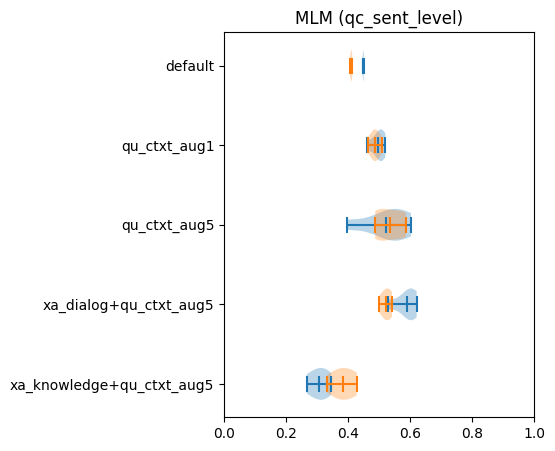

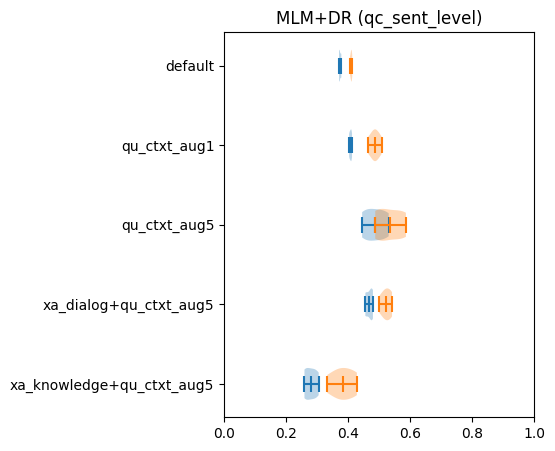

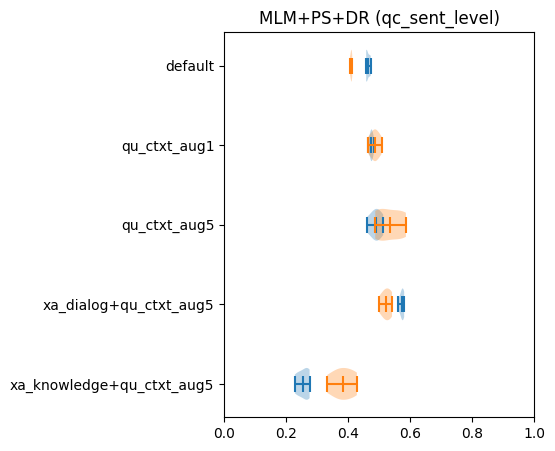

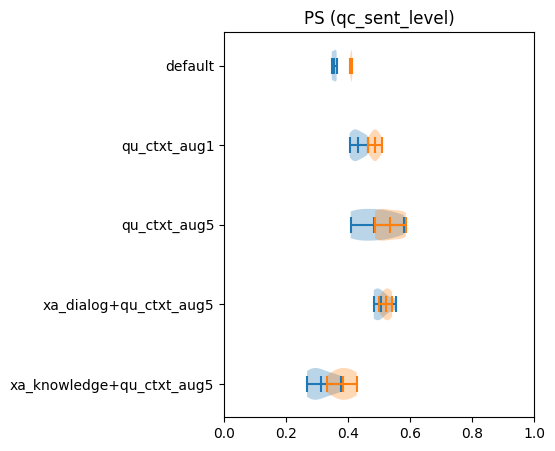

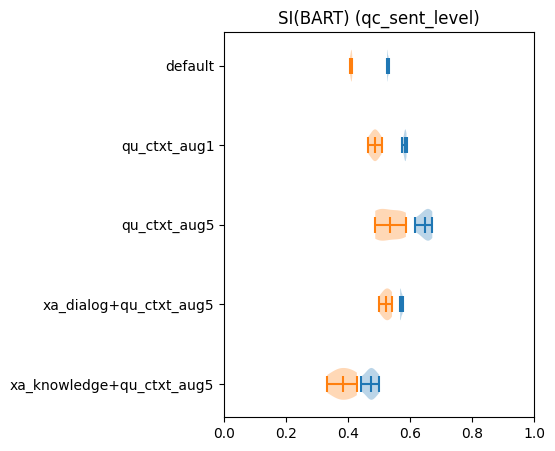

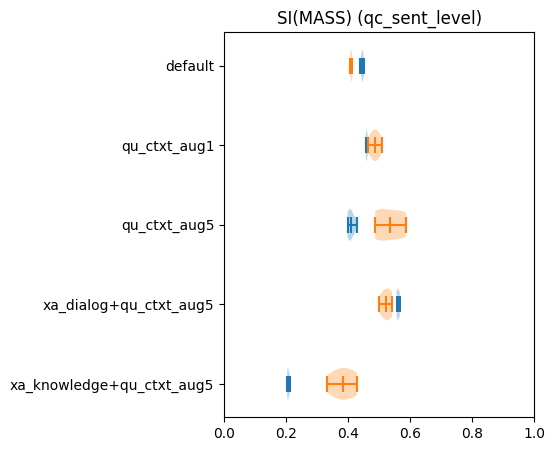

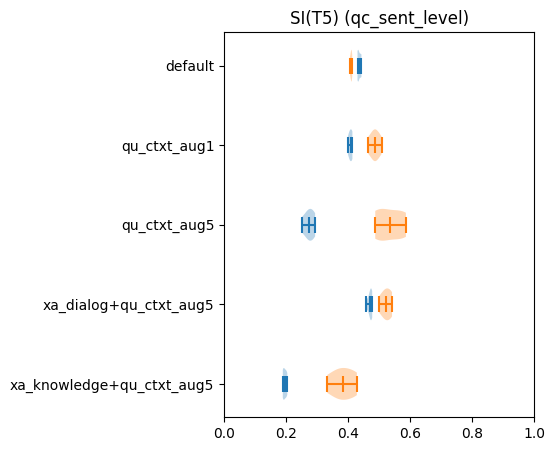

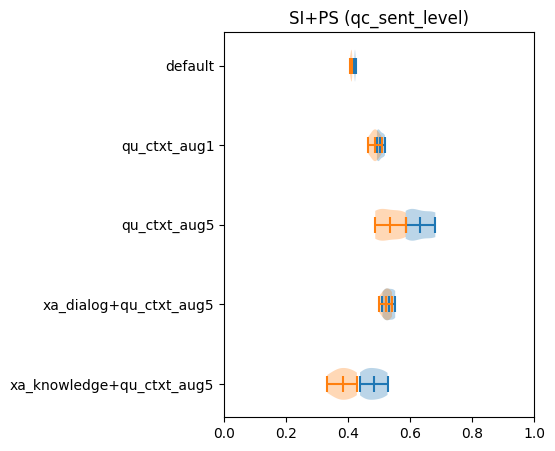

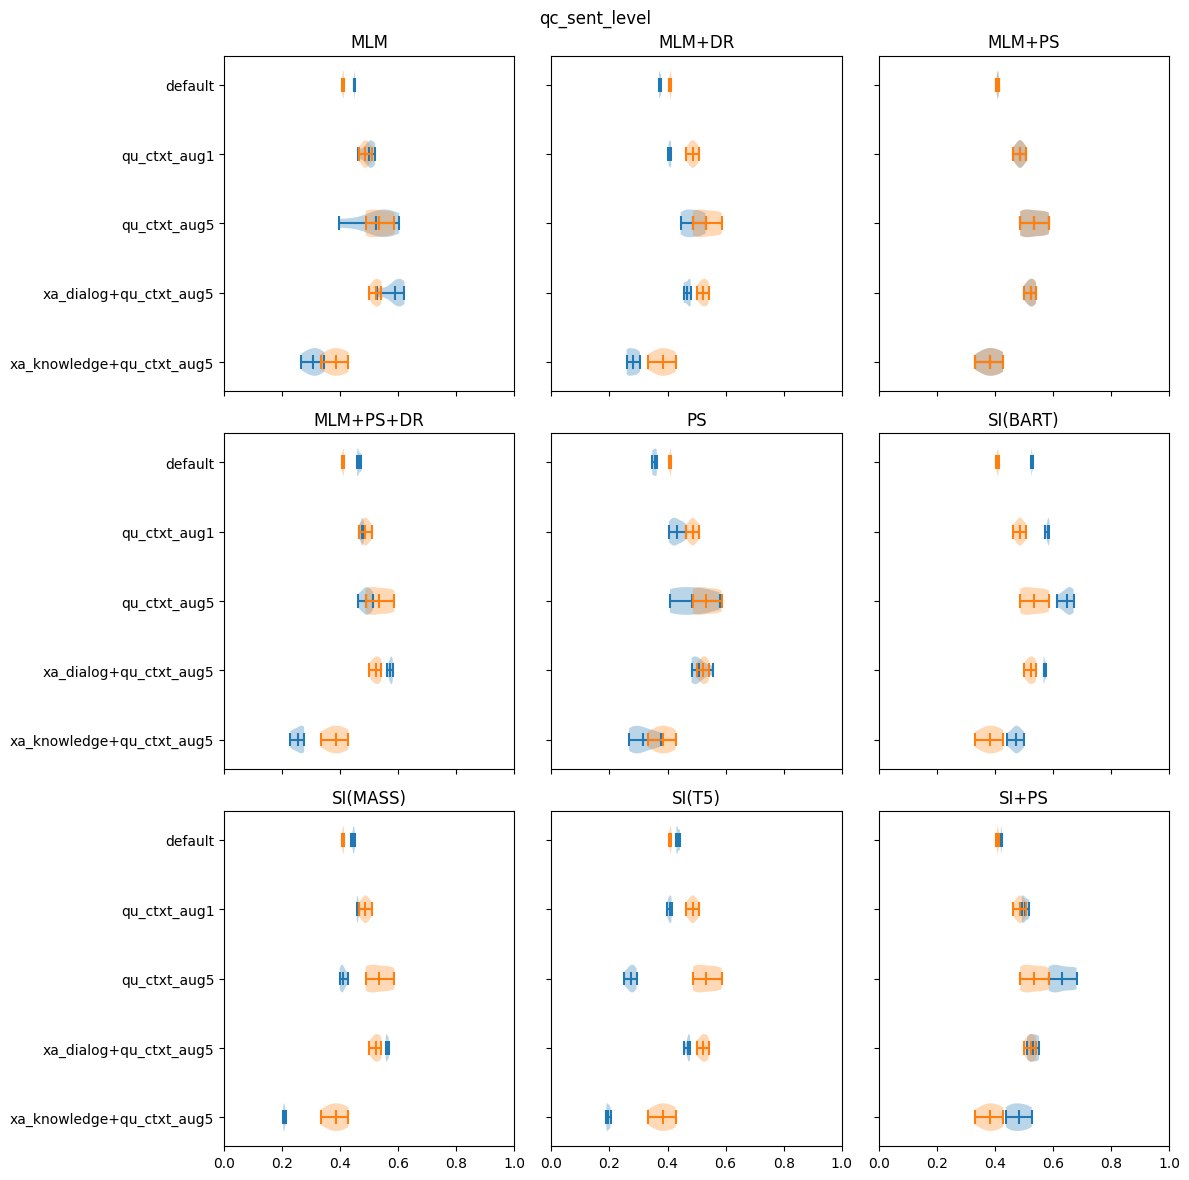

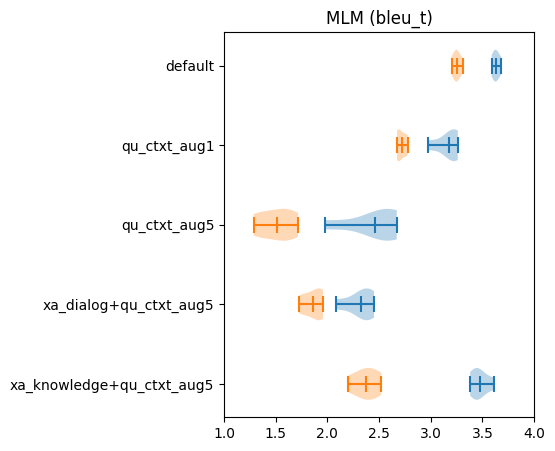

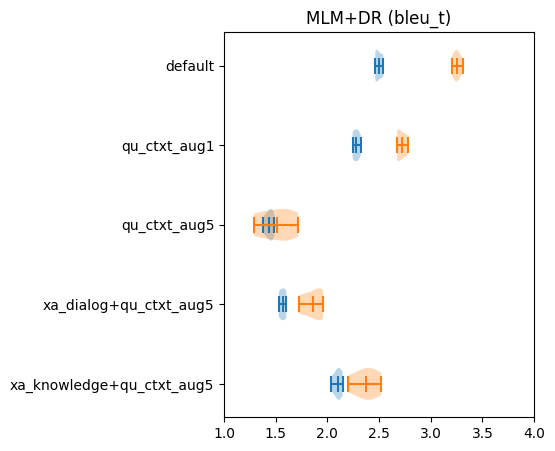

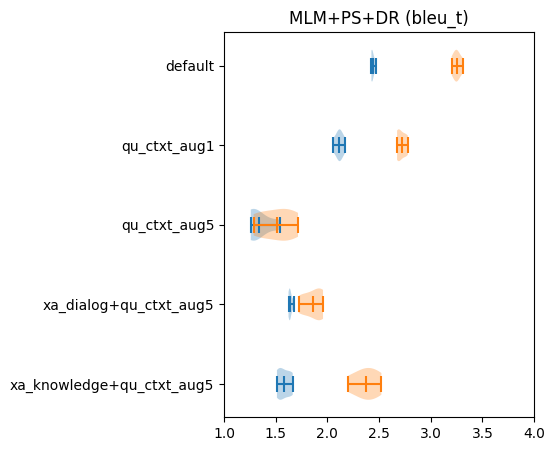

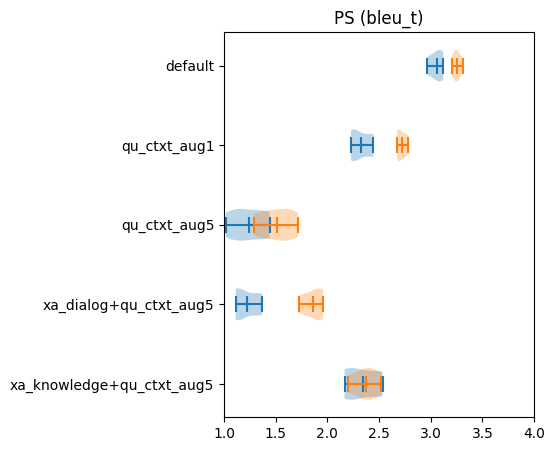

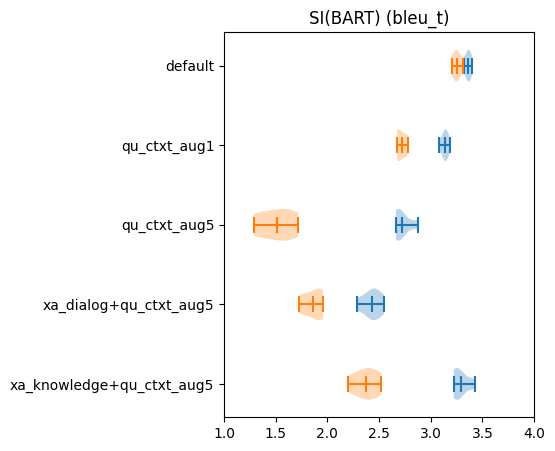

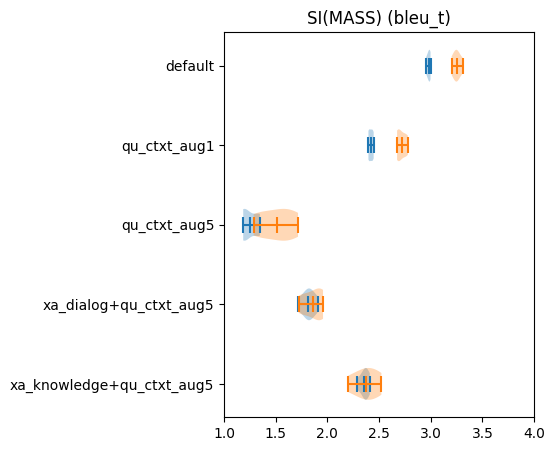

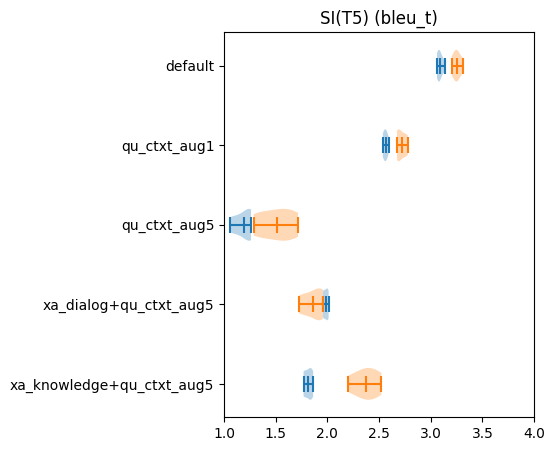

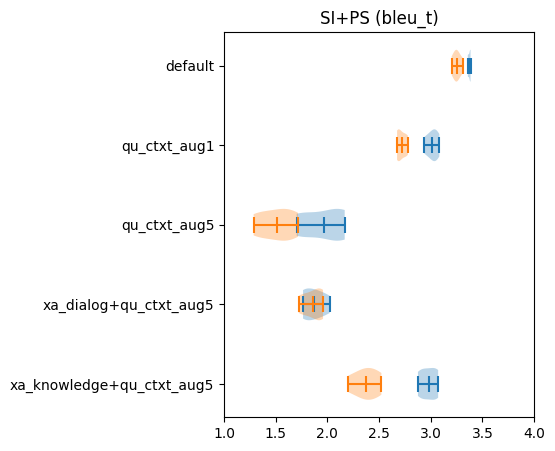

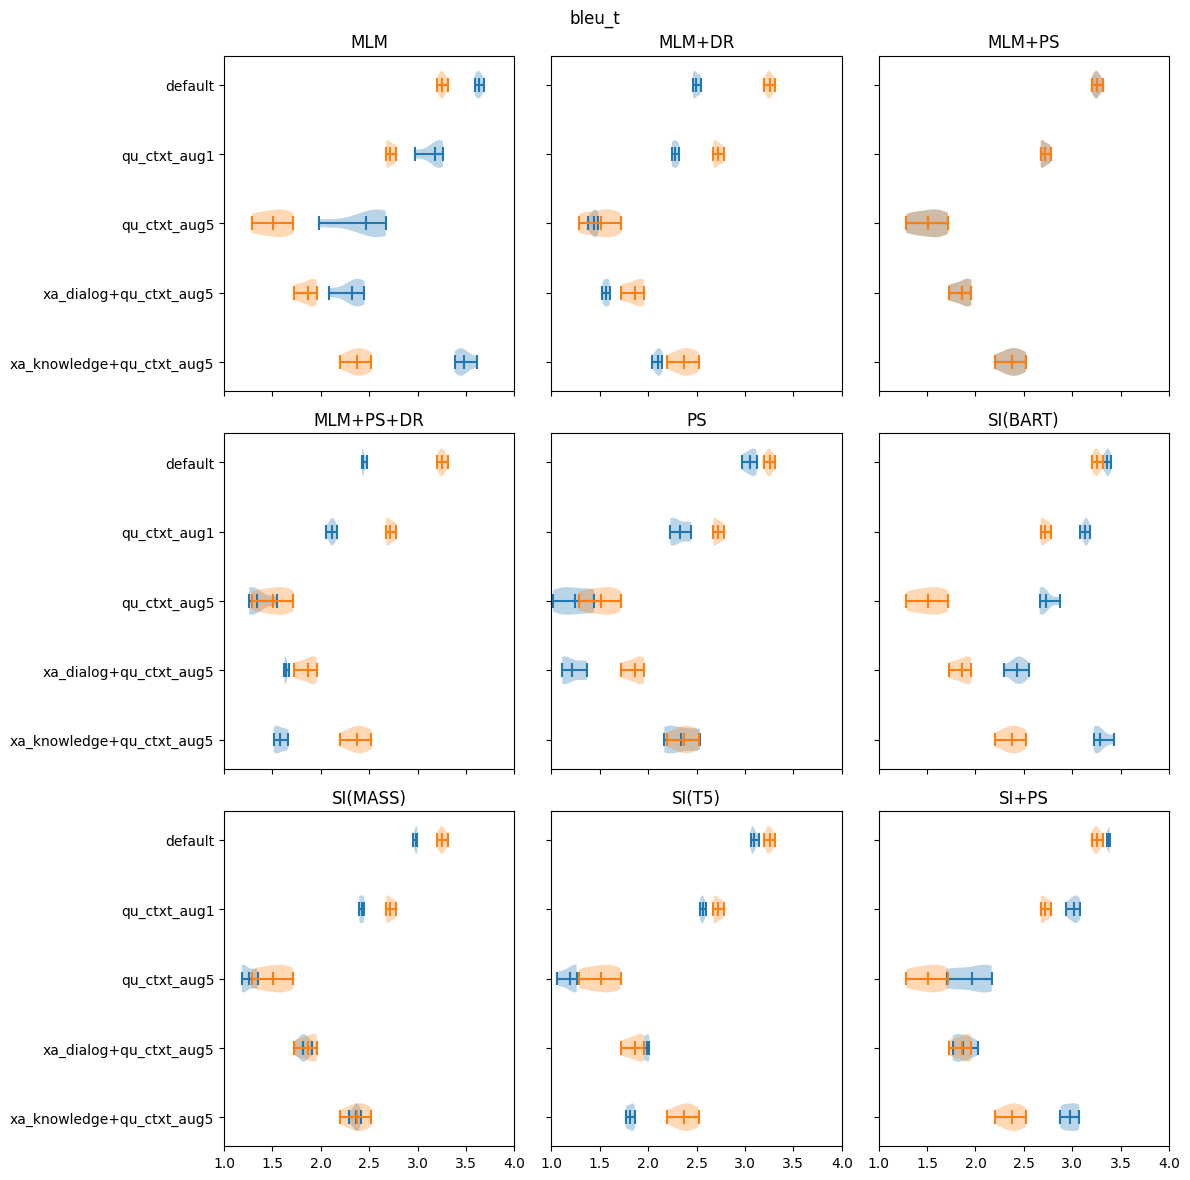

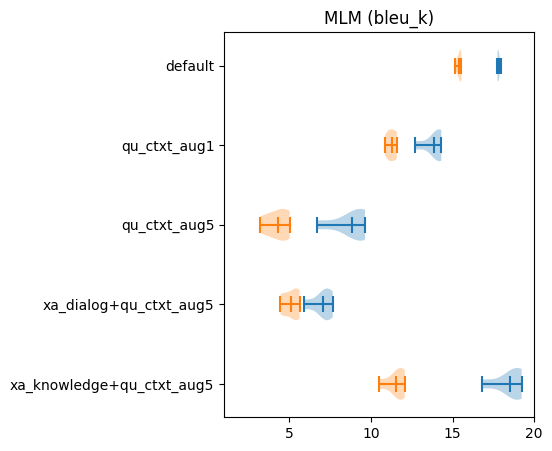

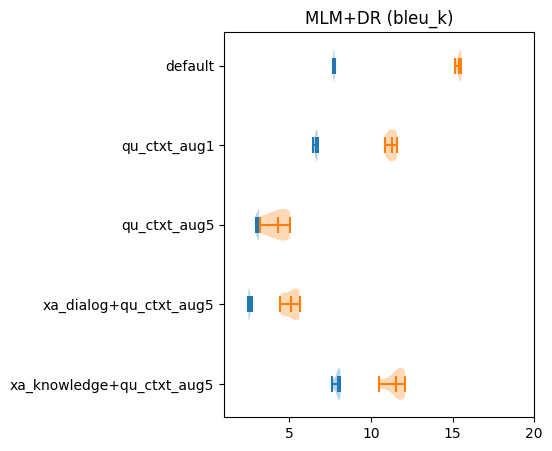

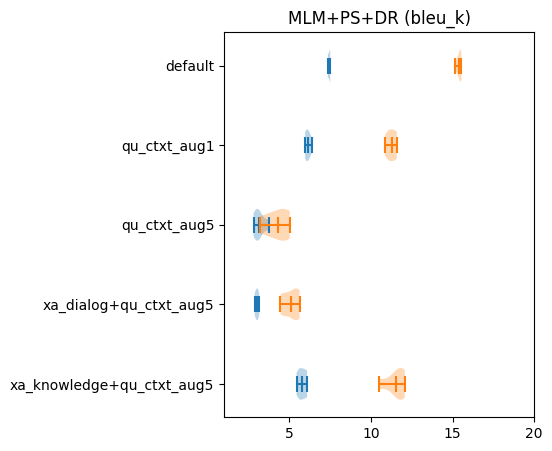

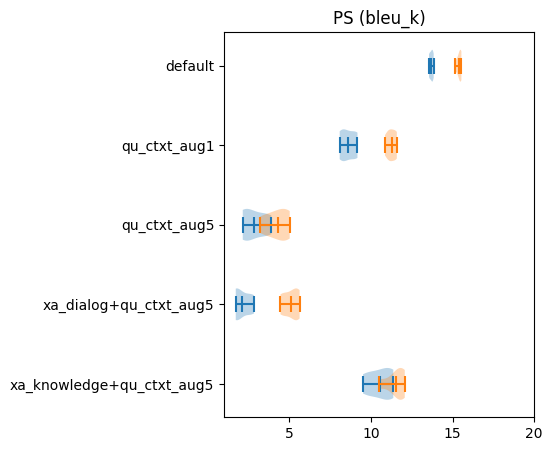

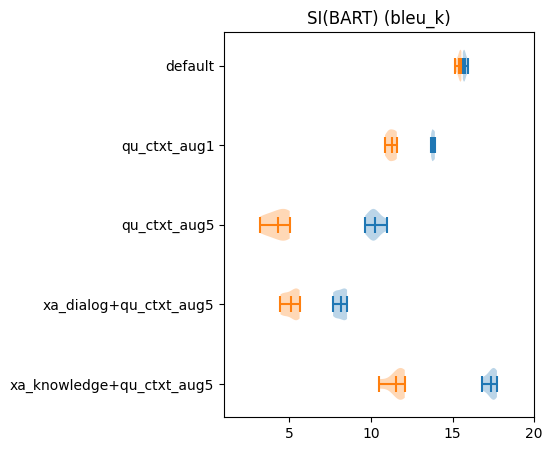

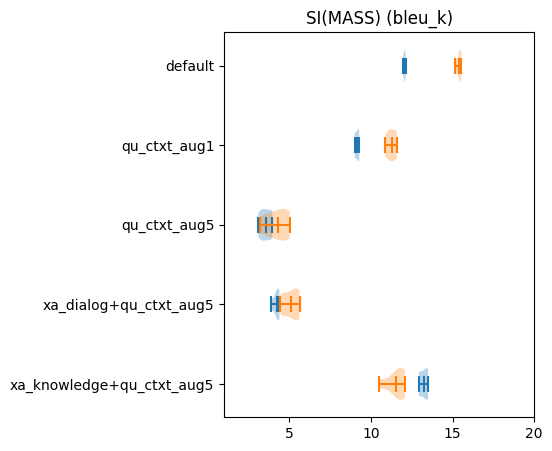

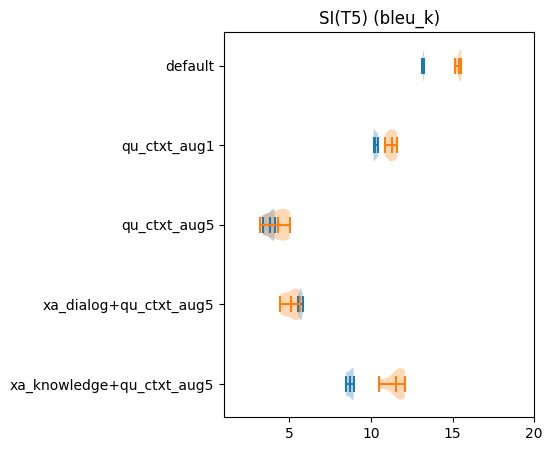

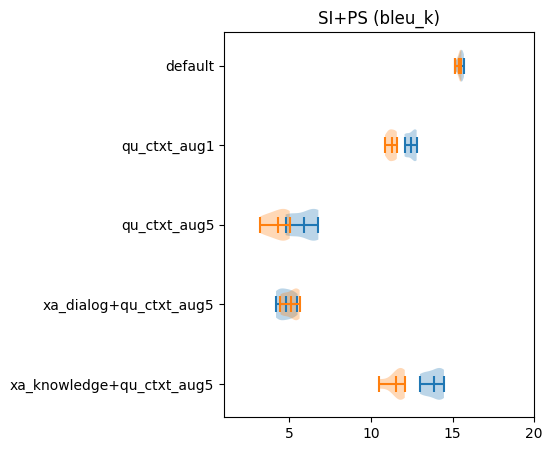

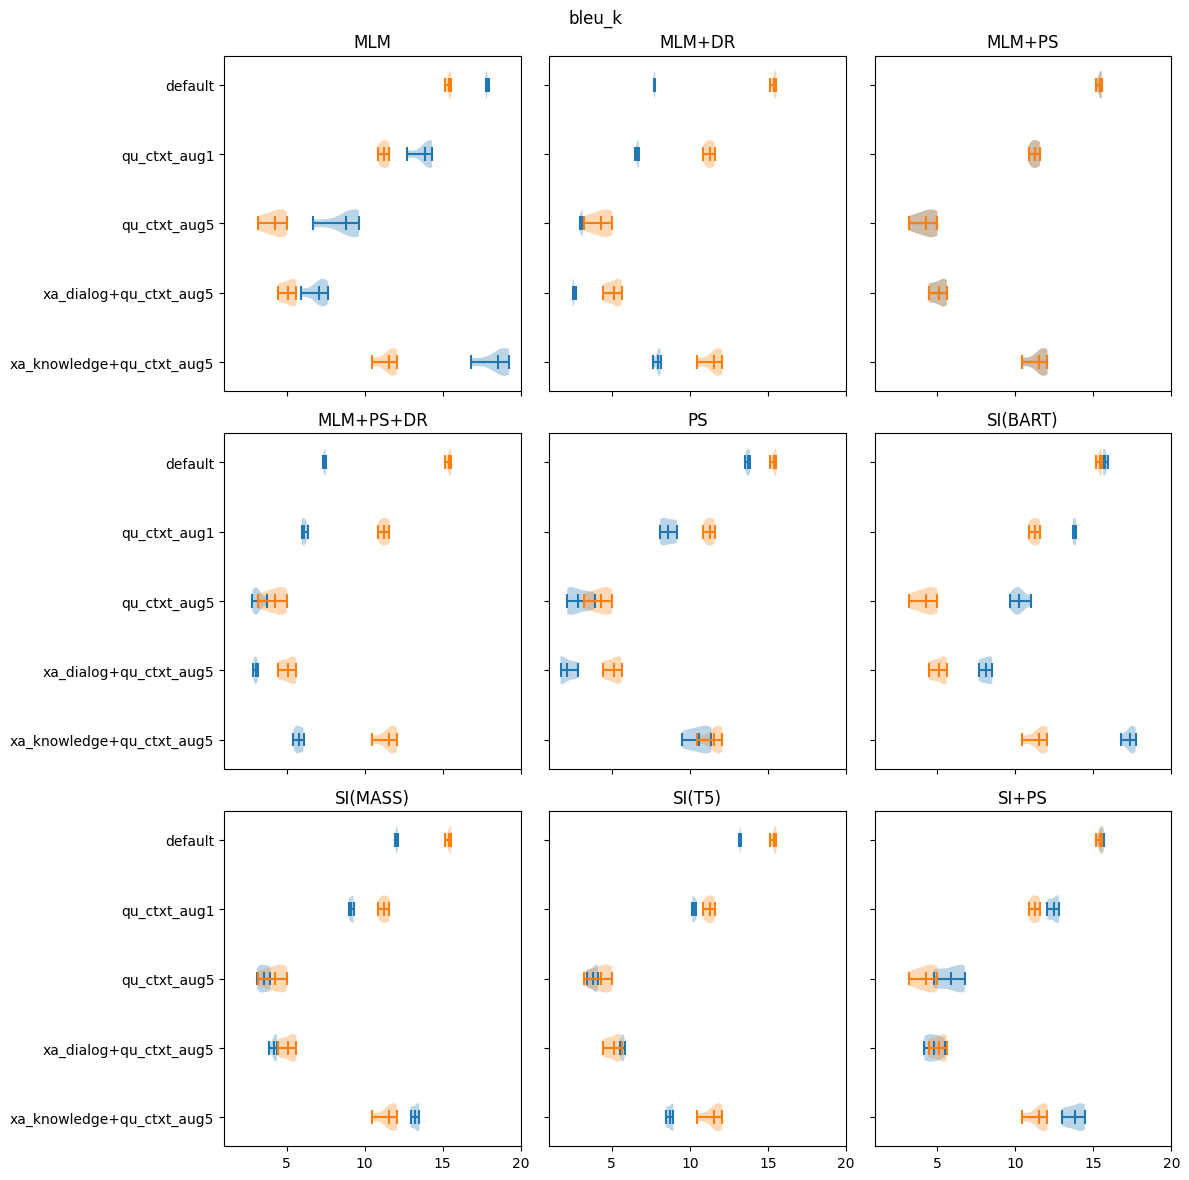

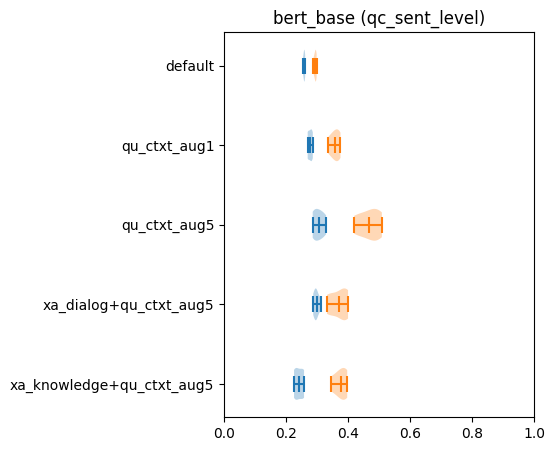

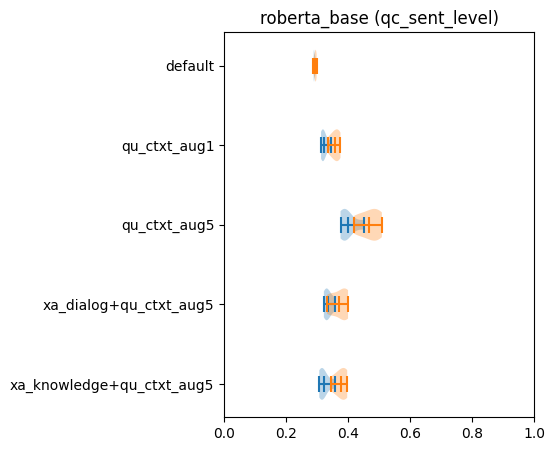

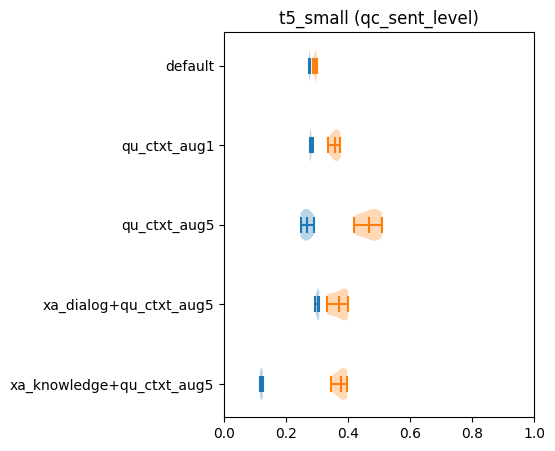

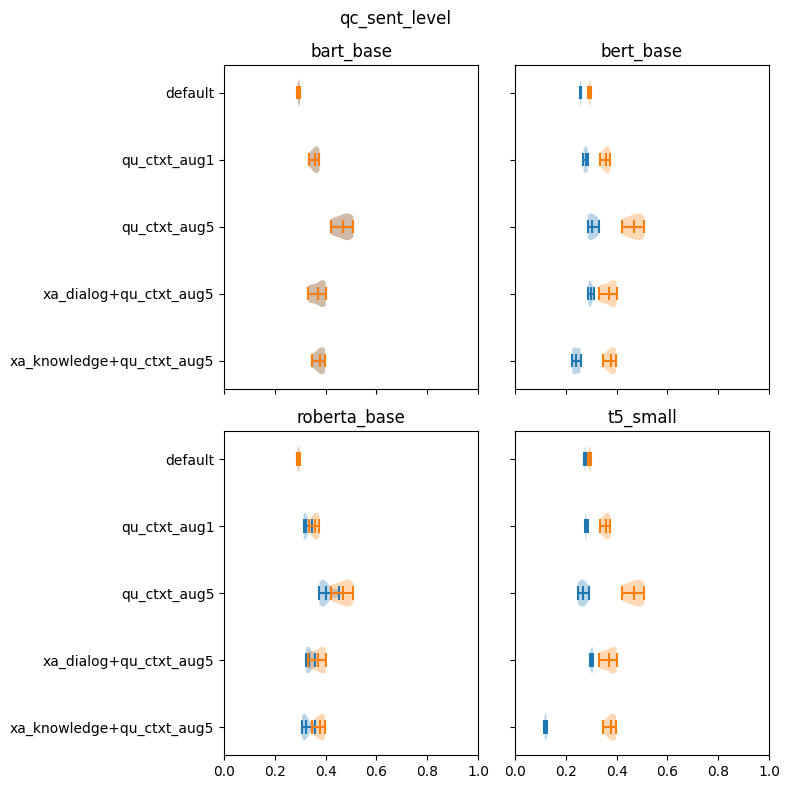

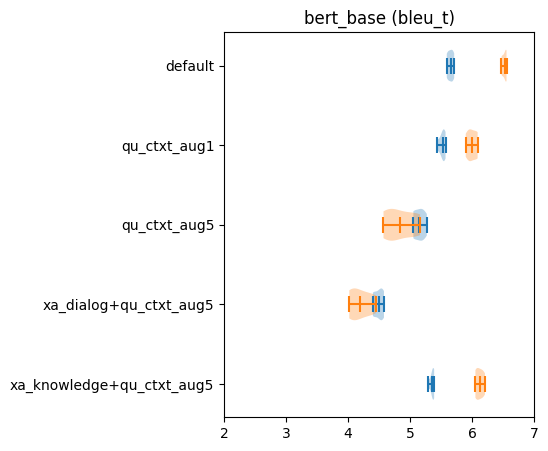

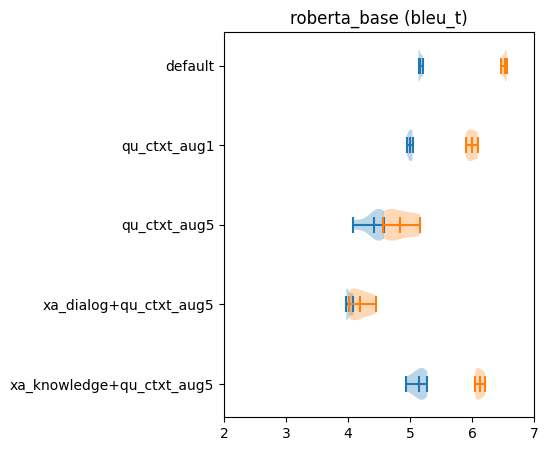

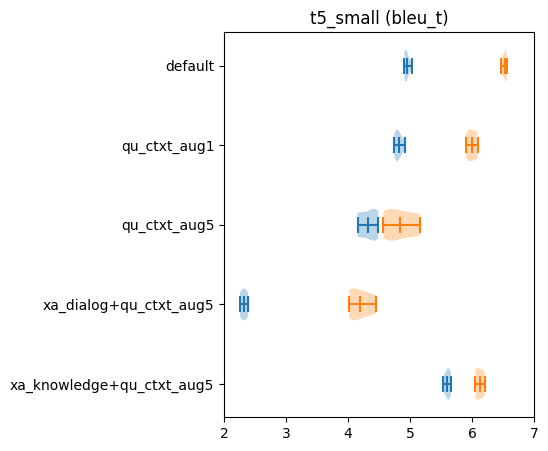

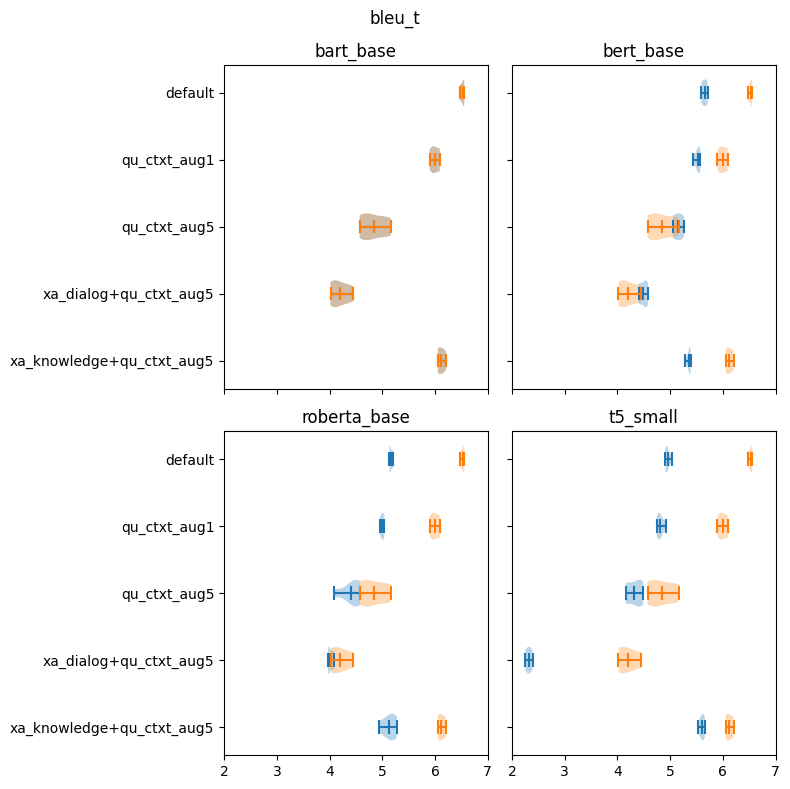

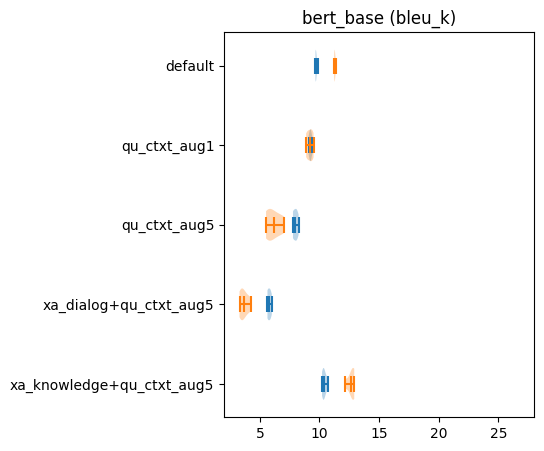

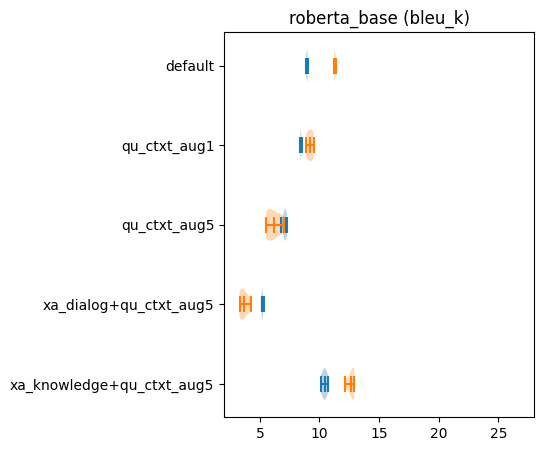

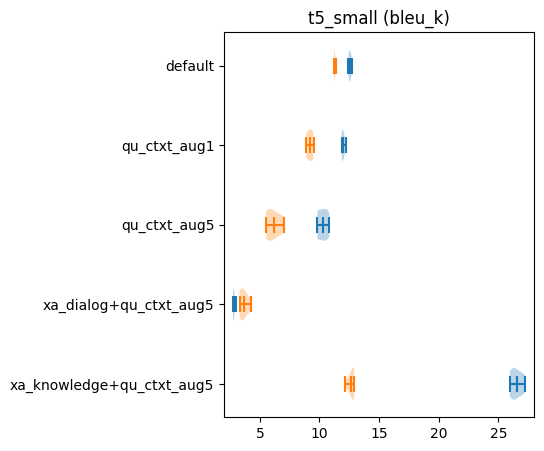

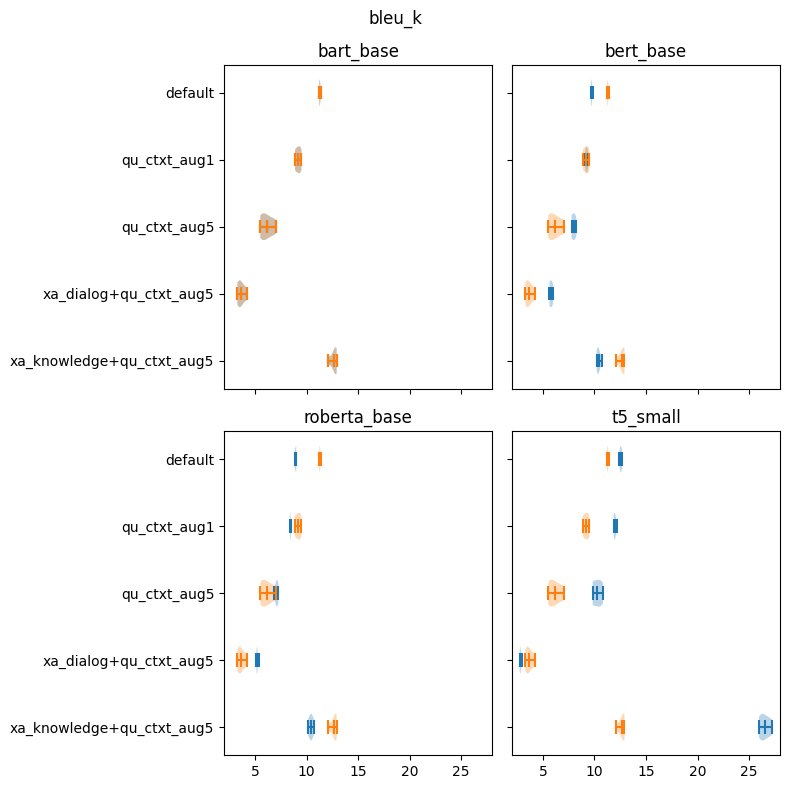

In [39]:
def parse_title(title):
    title = title.replace('bart_small', '')
    title = title.replace('(denoising)', '')
    title = title.replace('(denoising_t5)', 't5-style')
    return title

def build_violinplot(data: Dict, title: str, baseline_reference_data: Optional[Dict], min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 5))

    if verbose:
        print('Data:', data)

    positions = range(1, len(data)+1)[::-1] # reveserse to have defualt at top
    labels = list(data.keys())[::-1] # reveserse to have defualt at top
    
    vp1 = ax.violinplot(
        dataset = list(data.values()),
        positions=positions,
        points=30, widths=0.4,
        showmeans=True, showextrema=True, showmedians=False,
        vert=False,
    )
    if baseline_reference_data:
        vp2 = ax.violinplot(
            dataset = list(baseline_reference_data.values()),
            positions=positions,
            points=30, widths=0.4,
            showmeans=True, showextrema=True, showmedians=False,
            vert=False,
        )

        # create legend (currently v. rough)
        # plt.legend([vp1['bodies'][0], vp2['bodies'][0]], [title, 'default'], loc=2)
        
    # make title
    ax.set_title(parse_title(title)) 
    
    # label yaxis ticks
    ax.yaxis.set_tick_params(direction='out') 
    ax.yaxis.set_ticks_position('left')
    ax.set_yticks(np.arange(1, len(labels) + 1), labels=labels)
#     ax.set_ylabel('Generation setting')
    
    # set xaxis limits
    min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
    max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
    print(f'min={min_val}, max={max_val}')
    ax.set_xlim(min_val, max_val) #, + 0.75)

    return fig


def build_violinplot_subfig(data: Dict, target_metric: str = 'qc_sent_level', baseline_reference_key: str = None, min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):
    
    print('BASELINE model provided:', baseline_reference_key)
#     baseline_reference_data = data.pop(baseline_reference_key) if baseline_reference_key is not None else None
    baseline_reference_data = data.get(baseline_reference_key)
    model_array = list(data.keys())
    print(f'Plotting for models: {model_array}')
    
    if len(model_array) <= 3:
        # setup fig based on split arrays 1D
        
        print('Building single row plots...')
        nrows = 1
        ncols = len(model_array)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
        for i, model in enumerate(model_array):
            
            model_results = data[model]

            if baseline_reference_key is not None and baseline_reference_key != model:
                positions = range(1, len(data[model])+1)[::-1] # reveserse to have defualt at top
                labels = list(data[model].keys())[::-1] # reveserse to have defualt at top
                print(f'Plotting {model} on axes at position {i}')
                vp1 = axes[i].violinplot(
                    dataset = list(data[model].values()),
                    positions=positions,
                    points=30, widths=0.4,
                    showmeans=True, showextrema=True, showmedians=False,
                    vert=False,
                )
                if baseline_reference_data:
                    vp2 = axes[i].violinplot(
                        dataset = list(baseline_reference_data.values()),
                        positions=positions,
                        points=30, widths=0.4,
                        showmeans=True, showextrema=True, showmedians=False,
                        vert=False,
                    )
                # make title
                axes[i].set_title(parse_title(model))

        # label yaxis ticks
        axes[0].yaxis.set_tick_params(direction='out') 
        axes[0].yaxis.set_ticks_position('left')
        axes[0].set_yticks(np.arange(1, len(labels) + 1), labels=labels)
    #     axes[0].set_ylabel('Generation setting')

    #     # set xaxis limits
        min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
        max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
        print(f'min={min_val}, max={max_val}')
        axes[0].set_xlim(min_val, max_val) #, + 0.75)
    
    else:
        print('Building multi-row (2D) 3xN plots...')
        # setup fig based on split arrays 2D
        if len(model_array) <= 6:
            nrows = 2
        elif len(model_array) <= 9:
            nrows = 3
        elif len(model_array) <= 12:
            nrows = 4
        
        model_array = np.array_split(model_array, nrows)
        ncols = max([len(a) for a in model_array])
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
        for i, row in enumerate(model_array):
            for j, model in enumerate(row):
#                 if baseline_reference_key is not None and baseline_reference_key != model:
                positions = range(1, len(data[model])+1)[::-1] # reveserse to have defualt at top
                labels = list(data[model].keys())[::-1] # reveserse to have defualt at top
                print(f'Plotting {model} on axis at position {i}, {j}')
                vp1 = axes[i][j].violinplot(
                    dataset = list(data[model].values()),
                    positions=positions,
                    points=30, widths=0.4,
                    showmeans=True, showextrema=True, showmedians=False,
                    vert=False,
                )
                if baseline_reference_data:
                    vp2 = axes[i][j].violinplot(
                        dataset = list(baseline_reference_data.values()),
                        positions=positions,
                        points=30, widths=0.4,
                        showmeans=True, showextrema=True, showmedians=False,
                        vert=False,
                    )
                # make title
                axes[i][j].set_title(parse_title(model))

            # label yaxis ticks
            axes[0][0].yaxis.set_tick_params(direction='out') 
            axes[0][0].yaxis.set_ticks_position('left')
            axes[0][0].set_yticks(np.arange(1, len(labels) + 1), labels=labels)
            # axes[0][0].set_ylabel('Generation setting')

            # set xaxis limits
            min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
            max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
            print(f'min={min_val}, max={max_val}')
            axes[0][0].set_xlim(min_val, max_val) #, + 0.75)

    plt.suptitle(target_metric)
    plt.tight_layout()

    return fig

def build_violin_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', baseline_reference_key: str = None, min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

    # collect all the data for the relevant target metric first to set min and max vals for all plots
    data = {}
    for i, (model, dfx) in enumerate(df.groupby(level=0)):
        model_results = {}
        for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=1)):
            metric_scores = dfx[target_metric].values
            if min(metric_scores) < min_val:
                min_val = min(metric_scores)
            if max(metric_scores) > max_val:
                max_val = max(metric_scores)
            model_results[gen_setting] = metric_scores
        data[model] = model_results

    if verbose:
        print('Data:')
        print(data)
        
    baseline_reference_data = data[baseline_reference_key] if baseline_reference_key is not None else None
    
    # make violins for each model
    for model, results in data.items():
        if baseline_reference_key and baseline_reference_key != model:
            fig = build_violinplot(results, f'{model} ({target_metric})', baseline_reference_data, min_val, max_val, verbose=verbose)
            if save:
                outpath = str(plot_path / f'{model}-{target_metric}.png')
                fig.savefig(outpath, dpi='figure', bbox_inches='tight')
                print(f'saved {outpath}')
    
    # make a subfig for all models
    fig = build_violinplot_subfig(data, target_metric, baseline_reference_key, min_val, max_val, verbose=verbose)
    if save:
        outpath = str(plot_path / f'{baseline_reference_key}_vs_all-{target_metric}.png')
        fig.savefig(outpath, dpi='figure', bbox_inches='tight')
        print(f'saved {outpath}')

    
    return


# compare bart_base with bart_small
# dff = df[df.index.isin(['bart_base', 'bart_small(denoising)'], level=0)]
# build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='bart_base', save=True, verbose=False)

# # compare all bart_small models
dff = df.iloc[~df.index.get_level_values(0).str.contains('_')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
print(len(dff))
dff = dff.drop(['xa_dialog', 'xa_knowledge'], level=1, axis=0)
print(len(dff))
build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='MLM+PS', save=True, verbose=False)
build_violin_plots(dff, target_metric='bleu_t', baseline_reference_key='MLM+PS', save=True, verbose=False)
build_violin_plots(dff, target_metric='bleu_k', baseline_reference_key='MLM+PS', save=True, verbose=False)

# # # compare off-the-shelf fine-tuned models
dff = df.iloc[df.index.get_level_values(0).str.contains('_')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
print(len(dff))
dff = dff.drop(['xa_dialog', 'xa_knowledge'], level=1, axis=0)
print(len(dff))
build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='bart_base', save=True, verbose=False)
build_violin_plots(dff, target_metric='bleu_t', baseline_reference_key='bart_base', save=True, verbose=False)
build_violin_plots(dff, target_metric='bleu_k', baseline_reference_key='bart_base', save=True, verbose=False)



In [40]:
# import matplotlib.colors as mcolors
# colors = [mcolors.to_hex(plt.cm.tab20(i)) for i in range(20)]
# # patterns = ['', '\\', '+', 'x', '.', '*', 'o', 'O',]
# hpatterns = ['', '\\', '\\\\', '/', '//', '|', '||'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]
# vpatterns = ['', '\\', '\\\\', '/', '//', '-', '--'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]

# def build_bar_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', horizontal: bool = False, min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

#     # collect all the data for the relevant target metric first to set min and max vals for all plots
#     data = {}
#     for i, (model, dfx) in enumerate(df.groupby(level=0)):
#         model_results = {}
#         for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=1)):
#             metric_scores = dfx[target_metric].values
#             if min(metric_scores) < min_val:
#                 min_val = min(metric_scores)
#             if max(metric_scores) > max_val:
#                 max_val = max(metric_scores)
#             model_results[gen_setting] = metric_scores
#         data[model] = model_results

#     build_bar(data, horizontal=horizontal, verbose=verbose)
    
#     return


# def build_bar(data: Dict, horizontal: bool = True, verbose: bool = True):

#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

#     positions = []
#     means = []
#     stds = []
#     bar_colors = []
#     bar_patterns = []
#     labels = []
    
#     pos = 0
#     for i, (model, gen_settings) in enumerate(data.items()):
#         # TODO make groups for colors and build legend
#         # https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
# #                 group = {model: {}}
#         for j, (gen_setting, scores) in enumerate(gen_settings.items()):

#             labels.append(f'{model} {gen_setting}')
            
#             if not horizontal:
#                 ax.bar(
#                     x = pos,
#                     height = scores.mean(),
#                     yerr=scores.std(), 
#                     color=colors[i],
#                     hatch=vpatterns[j],
#                     label=f'{model} {gen_setting}'
#                 )
            
#             else:
#                 ax.barh(
#                     y = pos,
#                     width = scores.mean(),
#                     xerr=scores.std(), 
#                     color=colors[i],
#                     hatch=hpatterns[j],
#                     label=f'{model} {gen_setting}'
#                 )
            
#             pos += 1 # incrememt pos for next bar
        
#         if not horizontal:
#             ax.set_xticks(np.arange(len(labels)), labels=labels, rotation=45)
#         else:
#             ax.set_yticks(np.arange(len(labels)), labels=labels)
# #         ax.legend()
        
# dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
# build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)

# # dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
# # build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)


